Necessary imports:

In [3]:
import matplotlib.pylab as plt
import numpy as np
import glob
import skimage as ski
import skimage.morphology as mp
from skimage import io
from skimage.filters.edges import convolve
from skimage.util import img_as_float, img_as_ubyte
from skimage.color import rgb2gray
from scipy.ndimage import label, center_of_mass

from skimage.draw import circle_perimeter, disk

Global data:

In [4]:
# size of plot
columns = 6
rows = 3

# dimensions of images
images_dim = []

Implemented functions:

In [7]:
# read every image from file_path
def read_data(file_path):
    images = []
    for filename in glob.glob(file_path + '/*.jpg'):
        image = io.imread(filename)
        images.append(img_as_float(image)) # img_as_float converts from 0-255 to 0-1

        h, w = image.shape[:2]
        images_dim.append([h, w]) 
    return images

# common value, working for grayscaled images
def get_commmon_value(image):
    image = (image * 255).astype(np.uint8) # convert to 0-255 for bincount()
    flattened_image = image.flatten() # flatten to 1 dimensional array
    counts = np.bincount(flattened_image) # count every value
    most_common_value = np.argmax(counts) # get back to 0-1
    return most_common_value / 255

# show collection of images
def show_images(data, contours, centroids):
    fig, axs = plt.subplots(rows, columns, figsize=(16, 10))
    axs = axs.flatten()

    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    color_cycle[7] = 'aquamarine'
    color_cycle.append('lawngreen')
    last_used_color = len(color_cycle) - 1

    for i, ax in enumerate(axs):
        ax.imshow(data[i], cmap='gray')
        ax.axis('off')

        for j, contour in enumerate(contours[i]):
            last_used_color = (last_used_color + 1) % len(color_cycle)
            ax.plot(contour[:, 1], contour[:, 0], color=color_cycle[last_used_color])

        for j,centroid in enumerate(centroids[i]):
            ax.plot(int(centroid[1]), int(centroid[0]), marker='o', color='white')

    fig.tight_layout(pad=0.5)
    plt.show()

def convolve_images(image, k_array):
    k_array = k_array / k_array[k_array > 0].sum()

    image = convolve(image, k_array)
    
    return image

def contrast(image, perc):
    MIN = np.percentile(image, perc)
    MAX = np.percentile(image, 100-perc)
    norm = (image - MIN) / (MAX - MIN)
    norm[norm[:,:] > 1] = 1
    norm[norm[:,:] < 0] = 0

    return norm

# image binarization
def thresh(image, value):
    binary = (image > value)
    binary = np.uint8(binary)
    
    return binary

# turn blue values from rgb above a given value white
# leave the rest unchanged
def thresh_blue(image, value):
    binary = image[:,:,2] > value
    image = image * (1 - binary[:, :, np.newaxis]) * 1
    image = np.where(image == 0, 1, image)

    return image

def get_centroids(image):
    labeled_matrix, num_features = label(image)
    centroids = center_of_mass(image, labeled_matrix, range(1, num_features + 1))
    return centroids


# Main function:

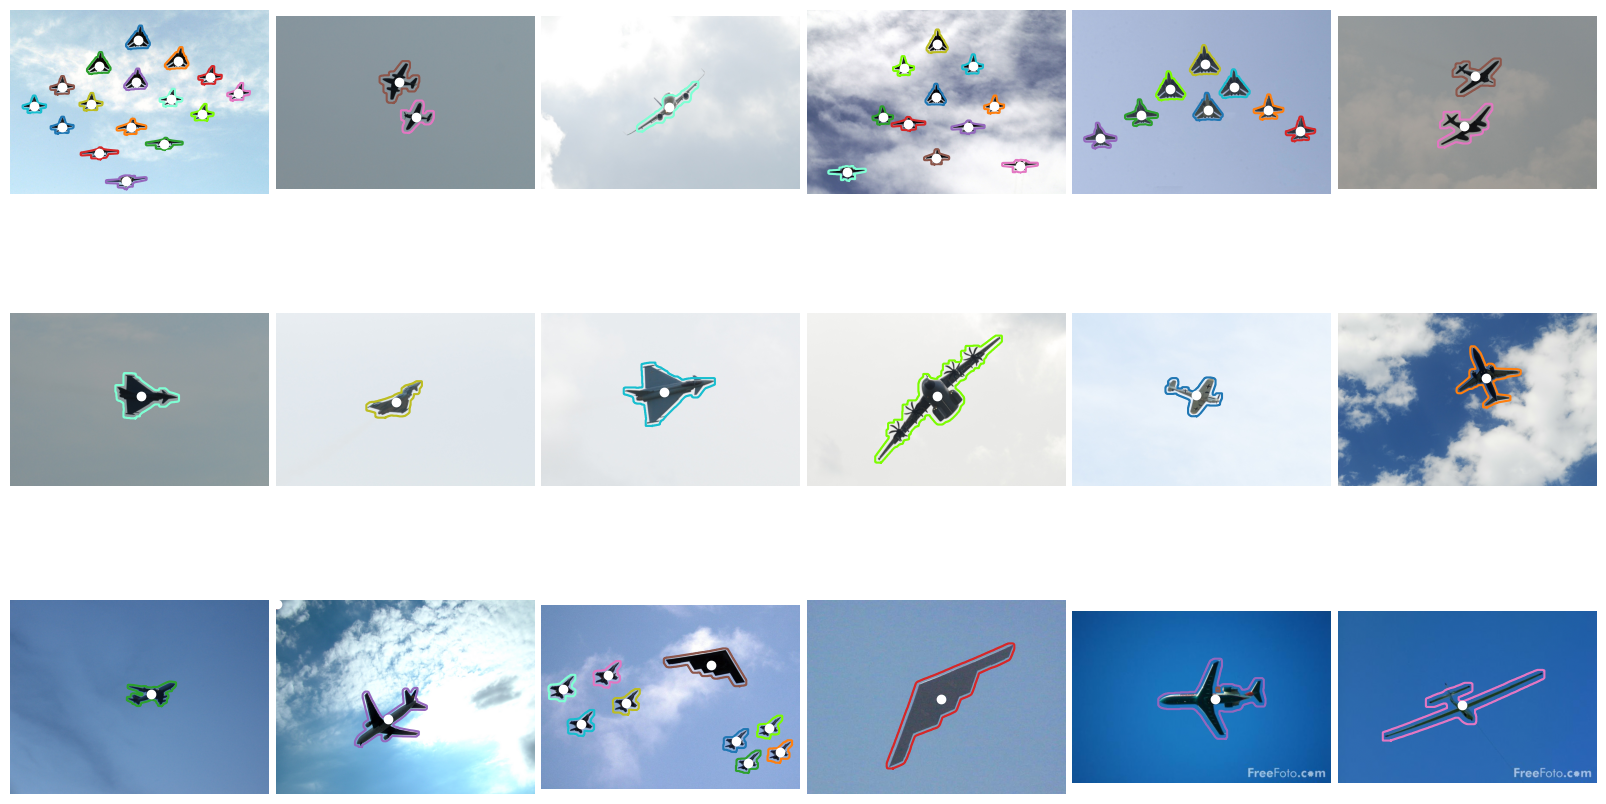

In [8]:
plane_images = read_data("data")
fixed_planes = []
contours = []
centroids = []

for image in plane_images:

    new_image = thresh_blue(image, 0.465)

    new_image = rgb2gray(new_image)

    # to be used when running thresh_blue with value of 0.48
    # new_image[:, 0:35] = 1 
    
    new_image = convolve_images(new_image, np.ones([11, 11])) # denoising
    new_image = 1 - new_image # fliping black with white 
    new_image = thresh(new_image, 0.1) # convert image to black and white only

    # TODO: test out denoising in place of some rounds of dilatation/erosion

    new_image = mp.binary_dilation(new_image, footprint=np.ones((17, 17)))
    new_image = mp.binary_erosion(new_image, footprint=np.ones((7, 7)))

    # equivalents of above operations

    # new_image = mp.binary_dilation(new_image)
    # new_image = mp.binary_dilation(new_image)
    # new_image = mp.binary_dilation(new_image)
    # new_image = mp.binary_dilation(new_image)
    # new_image = mp.binary_dilation(new_image)
    # new_image = mp.binary_dilation(new_image)
    # new_image = mp.binary_dilation(new_image)
    # new_image = mp.binary_dilation(new_image)
    # new_image = mp.binary_dilation(new_image)
    # new_image = mp.binary_dilation(new_image)
    # new_image = mp.binary_dilation(new_image)

    # new_image = mp.binary_erosion(new_image)
    # new_image = mp.binary_erosion(new_image)
    # new_image = mp.binary_erosion(new_image)
    centroids.append(get_centroids(new_image))
    contours.append(ski.measure.find_contours(new_image))
    fixed_planes.append(new_image)

show_images(plane_images, contours, centroids)